In [1]:
pip install torch torchvision
pip install git+https://github.com/openai/CLIP.git
pip install scipy

import torch
import clip

from PIL import Image
import os

import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
from scipy.stats import spearmanr
import os
import glob
import pandas as pd

In [3]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
def get_image_embedding(image):
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(preprocessed_image)
        return image_features
    
def get_text_embedding(text):
    with torch.no_grad():
        return model.encode_text(clip.tokenize([text]).to(device))


def get_images_from_folder(folder_path):
    images = []

    for filename in os.listdir(folder_path):
        # Check if the file is an image file
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Open the image using PIL
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            # Append the image to the list
            images.append(get_image_embedding(image))

    return images




In [7]:
def get_averaged_image_embedidng(image_folder_path, word):
        image_embeddings = get_images_from_folder(os.path.join(image_folder_path ,word))
        image_embeddings = torch.squeeze(torch.stack(image_embeddings, dim=0), dim=1)
        image_embeddings = torch.mean(image_embeddings, dim=0)
        return image_embeddings
    

In [8]:
def get_averaged_image_embedidng_after_normalization(image_folder_path, word):
        image_embeddings = get_images_from_folder(os.path.join(image_folder_path ,word))
        image_embeddings = torch.squeeze(torch.stack(image_embeddings, dim=0), dim=1)
        image_embeddings = torch.mean(image_embeddings, dim=0)
        image_embeddings = F.normalize(image_embeddings, p=2,dim=0)
        return image_embeddings

In [10]:
image_folder_path = "Dataset"
averaged_image_embeddings = {}


for word_directory in os.listdir(image_folder_path):
    image_embedidng = get_averaged_image_embedidng(image_folder_path, word_directory)
    averaged_image_embeddings[word_directory] = image_embedidng


In [ ]:
image_folder_path = "Dataset"
averaged_image_embeddings_after_normalization = {}


for word_directory in os.listdir(image_folder_path):
    image_embedidng = get_averaged_image_embedidng_after_normalization(image_folder_path, word_directory)
    averaged_image_embeddings_after_normalization[word_directory] = image_embedidng

d:\MS\COMP545\project\Investigating the Arithmetic of Visual Embeddings\.venv\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
def get_closest_vector(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in averaged_image_embeddings.items():
        # if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [ ]:
import re
import random

# Experiment 1:  Vector offset method on image embeddings obtained through CLIP
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        lines.append(line.strip())
        
pairs = lines
count = 0

random.shuffle(pairs)
results = []

for pair in pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
    

    embedding1 = averaged_image_embeddings[words[0]]
    embedding2 = averaged_image_embeddings[words[1]]
    embedding3 = averaged_image_embeddings[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector(offset_vector, words)
    query = pair
    actual_closest_word = words[3]
    
    print("Query ", query)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    print()
    
    record = {
        "Query ": query,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
    
df = pd.DataFrame(results)

df.to_csv('clip_image.csv', index=False)
    

In [ ]:
def get_closest_vector_after_normalization(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in averaged_image_embeddings_after_normalization.items():
        # if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [ ]:
import re
import random

# Experiment 2:  Vector offset method on image embeddings(Normalized) obtained through CLIP
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        lines.append(line.strip())
        
pairs = lines
count = 0

random.shuffle(pairs)
results = []

for pair in pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
    embedding1 = averaged_image_embeddings_after_normalization[words[0]]
    embedding2 = averaged_image_embeddings_after_normalization[words[1]]
    embedding3 = averaged_image_embeddings_after_normalization[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector_after_normalization(offset_vector, words)
    query = pair
    actual_closest_word = words[3]
    
    print("Query ", pair)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    
    record = {
        "Query ": pair,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
    
df = pd.DataFrame(results)

df.to_csv('image_results_after_normalization.csv', index=False)
    

In [29]:
import re
text_embeddings = {}

lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        lines.append(line.strip())
        
pairs = lines

for pair in pairs:
    words = [part for part in re.split(r'::|:', pair) if part]
    for word in words:
        text_embeddings[word] = get_text_embedding(word).squeeze(0)

In [30]:
def get_closest_words(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in text_embeddings.items():
        # if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [ ]:
import re
import random

# Experiment 3:  Vector offset method on Text embeddings obtained through CLIP
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        lines.append(line.strip())
        
pairs = lines
count = 0

results = []

for pair in pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
   
    word_embedding1 = get_text_embedding(words[0]).squeeze(0)
    word_embedding2 = get_text_embedding(words[1]).squeeze(0)
    word_embedding3 = get_text_embedding(words[2]).squeeze(0)
    
    offset_word = word_embedding2 - word_embedding1 + word_embedding3
    predicted_closest_words,answer_index,answer_similarity = get_closest_words(offset_word,words)

    print("Query ", pair)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    
    record = {
        "Query ": pair,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
df = pd.DataFrame(results)

df.to_csv('clip_text_results_all_pairs.csv', index=False)
    

In [ ]:
pip install gensim

In [36]:
import gensim.downloader as api

# Download and load the GoogleNews-vectors-negative300 Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

In [48]:
def get_w2v_text_embedding(word):
    if word in word2vec_model:
        return word2vec_model[word]
    
    return None

In [61]:
import re
w2v_text_embeddings = {}

lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        lines.append(line.strip())
        
pairs = lines

for pair in pairs:
    words = [part.replace('"','') for part in re.split(r'::|:', pair) if part]
    for word in words:
        emb =  get_w2v_text_embedding(word)
        if not emb is None:
            w2v_text_embeddings[word] = emb

In [63]:
def get_closest_words_w2v(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in w2v_text_embeddings.items():
        # if word not in words[:3]:
            if embedding is None:
                 print("embedding None", words)
            elif offset_vector is None:
                 print("offset vector none", words)
            cos_sim = F.cosine_similarity(offset_vector, torch.tensor(embedding), dim=0).item()
            # print(cos_sim)
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity
        

In [ ]:
import re
import random

# Experiment 4:  Vector offset method on text embeddings obtained through Word2Vec
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        lines.append(line.strip())
        
pairs = lines
count = 0


results = []

for pair in pairs:
#     print(pair)
    words = [part.replace('"','') for part in re.split(r'::|:', pair) if part]
#     print(words)
   
    if words[0] in w2v_text_embeddings and words[1] in w2v_text_embeddings and words[2] in w2v_text_embeddings:
        word_embedding1 = get_w2v_text_embedding(words[0])
        word_embedding2 = get_w2v_text_embedding(words[1])
        word_embedding3 = get_w2v_text_embedding(words[2])

        
        
        offset_word = word_embedding2 - word_embedding1 + word_embedding3
        # print(offset_word)
        predicted_closest_words,answer_index,answer_similarity = get_closest_words_w2v(torch.tensor(offset_word),words)

        print("Query ", pair)
        print("Actual closest word ", words[3])
        print("Predicted closest word for image ",predicted_closest_words)
        print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
        
        record = {
            "Query ": pair,
            "Actual closest word ": words[3],
            "Predicted closest words":predicted_closest_words,
            "Actual answer index": answer_index,
            "similarity score":answer_similarity
        }

        results.append(record)
    
df = pd.DataFrame(results)

df.to_csv('w2v_text_results_all_pairs.csv', index=False)
    

In [ ]:

import torch
import torchvision.transforms as transforms
import torchvision.models as models

resnet_model = models.resnet50(pretrained=True)
# Remove the final classification layer
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
resnet_model.eval()

# Preprocess the image
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_embedding_from_resnet(image):
    input_image = transform(image).unsqueeze(0)

    with torch.no_grad():
        embeddings = resnet_model(input_image)

    return embeddings


def get_resnet_image_embeddings(folder_path):
    images = []

    for filename in os.listdir(folder_path):
        # Check if the file is an image file
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Open the image using PIL
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            # Append the image to the list
            emb = get_image_embedding_from_resnet(image)
            print(emb.shape)
            images.append(emb)

    return images

def get_averaged_image_embedidng_resnet(image_folder_path, word):
        image_embeddings = get_resnet_image_embeddings(os.path.join(image_folder_path ,word))
        print(image_embedidng)
        image_embeddings = torch.squeeze(torch.stack(image_embeddings, dim=0), dim=1)
        image_embeddings = torch.mean(image_embeddings, dim=0)
        return image_embeddings


image_folder_path = "Datatset"
averaged_image_embeddings_resnet = {}


for word_directory in os.listdir(image_folder_path):
    image_embedidng = get_averaged_image_embedidng_resnet(image_folder_path, word_directory)
    averaged_image_embeddings_resnet[word_directory] = image_embedidng

In [24]:
def get_closest_vector_resnet(offset_vector,words):
    closest_words = []
    
    word_cos_sim = {}
    for word,embedding in averaged_image_embeddings_resnet.items():
        # if word not in words[:3]:
            cos_sim = F.cosine_similarity(offset_vector, embedding, dim=0).item()
            word_cos_sim[word] = cos_sim
            
    sorted_dict = sorted(word_cos_sim.items(), key=lambda x: x[1], reverse=True)
    top_10 = [(key, value) for key, value in sorted_dict][:10]

    answer_index = 0
    answer_similarity = -1
    for key,value in sorted_dict:
        if key == words[3]:
            answer_similarity = value
            answer_index  = answer_index  + 1
            break
        answer_index  = answer_index  + 1
        
    
    # print(top_10)
    # print(answer_index)
    # print(answer_similarity)
    return top_10,answer_index,answer_similarity

In [ ]:
import re
import random

# Experiment 5:  Vector offset method on image embeddings obtained through ResNet-50
lines = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        lines.append(line.strip())
        
pairs = lines
count = 0


results = []

for pair in pairs:
#     print(pair)
    words = [part for part in re.split(r'::|:', pair) if part]
#     print(words)
    
    # random_pair2 = random.choice(pair2)
    # words = []
    # words.extend(pair.split(":"))
    # words.extend(random_pair2.split(":"))

    embedding1 = averaged_image_embeddings_resnet[words[0]]
    embedding2 = averaged_image_embeddings_resnet[words[1]]
    embedding3 = averaged_image_embeddings_resnet[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector_resnet(offset_vector, words)
    query = pair
    actual_closest_word = words[3]
    
    print("Query ", query)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    print()
    
    record = {
        "Query ": query,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
df = pd.DataFrame(results)

df.to_csv('resnet_image.csv', index=False)
    

In [ ]:
pair1 = []
pair2 = []

with open('D:\\MS\\COMP545\\project\\Investigating the Arithmetic of Visual Embeddings\\Analogy-pairs.txt', 'r') as file:
    for line in file:
        # Remove newline character at the end of each line and append to the list
        pairs = line.strip().split("::")
        pair1.append(pairs[0])
        pair2.append(pairs[1])


In [ ]:
import re
import random

# Experiment 6:  Vector offset method on image embeddings obtained through CLIP : The pairs are chosen randomly
lines = []
count = 0

random.shuffle(pairs)
results = []

for pair in pair1:
    
    random_pair2 = random.choice(pair2)

    words = []
    words.extend(pair.split(":"))
    words.extend(random_pair2.split(":"))

    embedding1 = averaged_image_embeddings[words[0]]
    embedding2 = averaged_image_embeddings[words[1]]
    embedding3 = averaged_image_embeddings[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector(offset_vector, words)
    query = pair
    actual_closest_word = words[3]
    
    print("Query ", query)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    print()
    
    record = {
        "Query ": query,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    
    
df = pd.DataFrame(results)

df.to_csv('clip_image_random_pairing.csv', index=False)
    

In [ ]:
cs = pd.read_csv("clip_image_random_pairing.csv")
random_pairs = cs['Query']

In [ ]:
import re
import random

# Experiment 7:  Vector offset method on image embeddings obtained through ResNet-50 : The pairs are chosen randomly
results = []

for pair in random_pairs:
    words = [part for part in re.split(r' |:', pair) if part]

    embedding1 = averaged_image_embeddings_resnet[words[0]]
    embedding2 = averaged_image_embeddings_resnet[words[1]]
    embedding3 = averaged_image_embeddings_resnet[words[2]]
    
    offset_vector = embedding2 - embedding1 + embedding3
    
    predicted_closest_words,answer_index,answer_similarity = get_closest_vector_resnet(offset_vector, words)
    query = pair 
    actual_closest_word = words[3]
    
    print("Query ", query)
    print("Actual closest word ", words[3])
    print("Predicted closest word for image ",predicted_closest_words)
    print("Actual answer index:", answer_index , " and similarity score =",answer_similarity)
    print()
    
    record = {
        "Query ": query,
        "Actual closest word ": words[3],
        "Predicted closest words":predicted_closest_words,
        "Actual answer index": answer_index,
        "similarity score":answer_similarity
    }

    results.append(record)
    

    
df = pd.DataFrame(results)

df.to_csv('resnet_image_random_pairing_aligned_clip.csv', index=False)
    

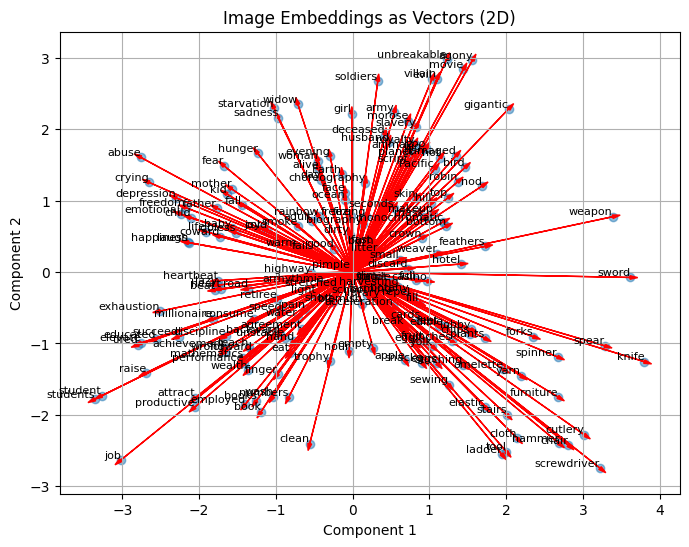

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embeddings_array = np.vstack(list(averaged_image_embeddings.values()))
labels = np.hstack(list(averaged_image_embeddings.keys()))

# Apply PCA for dimensionality reduction to 2 dimensions
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Plot the embeddings as vectors
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('Image Embeddings as Vectors (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Optionally, plot vectors connecting each point to the origin
for i in range(len(embeddings_2d)):
    plt.arrow(0, 0, embeddings_2d[i, 0], embeddings_2d[i, 1], head_width=0.05, head_length=0.1, fc='r', ec='r')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], labels[i], fontsize=8, ha='right', va='bottom')

plt.grid(True)
plt.show()


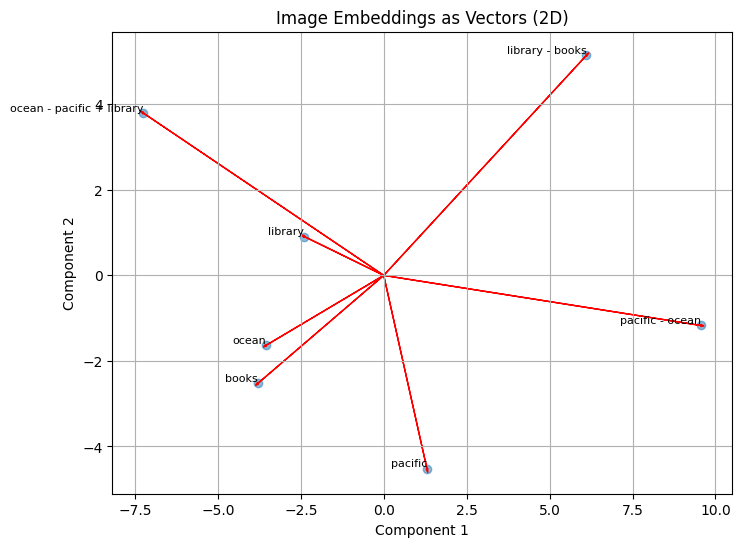

In [ ]:
pacific = averaged_image_embeddings['Pacific']
ocean = averaged_image_embeddings['ocean']
library = averaged_image_embeddings['library']
books = averaged_image_embeddings['books']

pacific_ocean = pacific - ocean

library_books = library - books

ocean_pacific_library = ocean - pacific + library

final_array = np.vstack((pacific, ocean, library, books, pacific_ocean, library_books, ocean_pacific_library))

final_array.shape

labels = np.array(['pacific','ocean','library','books','pacific - ocean','library - books', 'ocean - pacific + library'])

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(final_array)

# Plot the embeddings as vectors
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('Image Embeddings as Vectors (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Optionally, plot vectors connecting each point to the origin
for i in range(len(embeddings_2d)):
    plt.arrow(0, 0, embeddings_2d[i, 0], embeddings_2d[i, 1], head_width=0.05, head_length=0.1, fc='r', ec='r')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], labels[i], fontsize=8, ha='right', va='bottom')

plt.grid(True)
plt.show()